In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from lstm2 import LSTMModel
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss
from gru2 import GRUModel

(1000, 2000, 7)
(1000, 2000, 5)


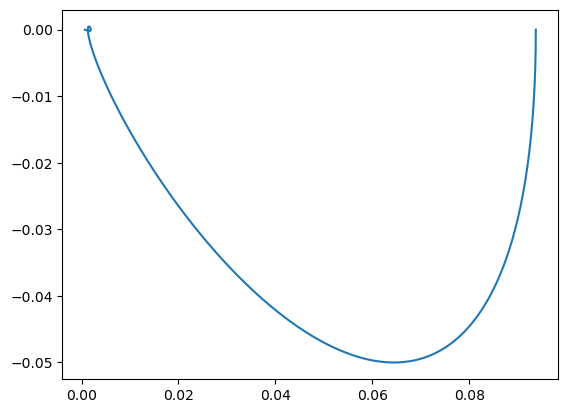

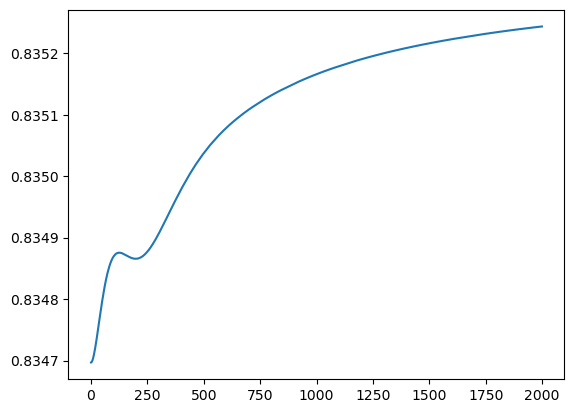

In [2]:
# Load Data

T = 20
dt = 0.01
nt = int(round(T/dt))
npoints = 1000
t1 = np.linspace(0, T, nt)
 
x = np.loadtxt("xAlpha.dat", dtype=np.float32)
x = x.reshape(
    x.shape[0], x.shape[1] // 7, 7)
y = np.loadtxt("y.dat", dtype=np.float32)
y = y.reshape(
    y.shape[0], y.shape[1] // 5, 5)

phi = x[0].transpose()[0]
p = x[0].transpose()[1]
plt.plot(phi, p)
plt.figure()
theta = y[0].transpose()
plt.plot(theta[2])

print(x.shape)
print(y.shape)

In [3]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes = 12
width = 32

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

# Normalize
x_normalizer = UnitGaussianNormalizer(x_train)
y_normalizer = UnitGaussianNormalizer(y_train)
x_train  = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)
y_train = y_normalizer.encode(y_train)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [26]:
model = LSTMModel(850, 7, 5).cuda()
print(count_params(model))

2924855
/home/luke/observer/aircraft/lstm


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            out = y_normalizer.decode(out)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    print(ep, t2-t1, train_mse, test_mse)

0 6.047484103823081 0.49023576080799103 0.18794705271720885
1 5.857685790164396 0.19439052674505447 0.2081261992454529
2 5.787162757012993 0.1625993952155113 0.0904274582862854
3 5.822057220153511 0.1279306454790963 0.07466388419270516
4 5.952581162098795 0.07761633905271689 0.053848288208246234
5 5.969995473045856 0.11158264130353927 0.10283668637275696
6 5.828672643983737 0.08683748659160402 0.0578740693628788
7 5.936002621194348 0.05410364468892415 0.04280155152082443
8 5.9684954630211 0.1305367246684101 0.06194376051425934
9 5.831261039944366 0.07307999568680922 0.21049429327249528
10 5.84259811998345 0.09937364293469322 0.038494788110256195
11 5.832369387848303 0.04869043752551079 0.07722037956118584
12 5.817001793067902 0.08236243513723214 0.06441266238689422
13 5.874186631990597 0.04548861802452141 0.030448080226778983
14 5.90593237685971 0.0347739915880892 0.04143543913960457
15 5.9605946380179375 0.04135101532770528 0.031343792006373404
16 6.0259553759824485 0.0928564993043740

132 5.908537802984938 0.023688889108598232 0.014487136900424958
133 5.907665473176166 0.01837598735259639 0.01023226696997881
134 5.910393906990066 0.013570966043819984 0.011693406477570533
135 5.9091537729837 0.013851924592422115 0.011036541126668454
136 5.88394307019189 0.013192488635993666 0.009652546234428882
137 5.847564144991338 0.012319522299286392 0.010378170013427734
138 6.060334390960634 0.01233678687777784 0.010686003789305686
139 5.926158322952688 0.011884628050029277 0.010455521754920483
140 5.909361464902759 0.01153332699711124 0.03036758415400982
141 5.913313003024086 0.019743748526606295 0.009821856953203678
142 5.911814583931118 0.016983249131590127 0.011903705447912217
143 5.848230549832806 0.01427141950569219 0.009912550449371338
144 6.055148652056232 0.016347666850520505 0.018858138285577298
145 5.8605802860111 0.01501563342495097 0.012636924535036087
146 5.939455593936145 0.015574711923384004 0.012115322425961495
147 5.890547974035144 0.0167910722291304 0.010529609

261 11.915378539124504 0.007652337735311853 0.006753220595419407
262 11.941431877901778 0.007768354430380795 0.007044677808880806
263 11.852959839859977 0.0076968802656564445 0.006833689101040363
264 11.828376030083746 0.007719494454148743 0.006837059836834669
265 11.846984670963138 0.00853560334071517 0.0077639099210500715
266 11.84621922718361 0.008336806090341674 0.007174685038626194
267 11.876732622971758 0.007840987346652482 0.006741147488355637
268 11.831497642910108 0.008164408751246003 0.007039744779467583
269 11.850152526982129 0.008345265169110563 0.007508349139243364
270 11.847253817832097 0.008039243270953495 0.007067327667027712
271 11.85443778987974 0.008215508848014806 0.006844705995172262
272 11.820446469821036 0.007537347895817624 0.006695794221013784
273 11.864486539037898 0.007982838184883196 0.006719922926276922
274 11.874643728137016 0.007619535426298777 0.007606446836143732
275 11.930168144172058 0.008170309248897764 0.0066987845115363594
276 11.873778169974685 0.

388 11.941765989176929 0.006828566609571377 0.0060602638870477675
389 11.916886867024004 0.006804538466450241 0.006035258062183857
390 11.872599138878286 0.00681982125259108 0.006058079563081265
391 11.960656827082857 0.006844710807005564 0.006046893820166588
392 12.062821776838973 0.0068098625582125455 0.0060308721847832205
393 12.13400372187607 0.006800054365562068 0.006043656170368195
394 12.076520516071469 0.006780409823275275 0.006032291613519192
395 11.975515611004084 0.006855555396113131 0.006128957588225603
396 11.991522281197831 0.00695398955916365 0.006152465008199215
397 11.939304691040888 0.006908953055325482 0.006192148104310036
398 11.924545008921996 0.006788358402748902 0.006076760124415159
399 11.970374729018658 0.006813316543896993 0.006032430380582809
400 11.910512884147465 0.006789689780109459 0.0060178952291607855
401 11.906237635063007 0.006753213465627697 0.006012566480785608
402 11.884559194091707 0.006746430601924658 0.006005329638719558
403 11.897096964996308 0

515 11.79858588706702 0.0066168374381959435 0.0059039581567049025
516 11.8059171740897 0.00661931305916773 0.005909114610403776
517 11.801491942955181 0.006613106466829777 0.005900279898196459
518 11.811572232050821 0.006625529130299886 0.005907909292727709
519 11.79919469798915 0.00661590454272098 0.005902766901999712
520 11.807980953948572 0.006613937268654505 0.005901049822568893
521 11.798045843839645 0.006618077773600817 0.005906720831990242
522 11.803771610138938 0.0066160489598082175 0.005908928718417883
523 11.79837494296953 0.006613589823246002 0.0058985274285078045
524 11.807714060181752 0.006615190301090479 0.005898562446236611
525 11.801092559937388 0.006615564258148273 0.005908443126827478
526 11.805673772003502 0.006614195731365019 0.005912477150559425
527 11.799972672946751 0.006618225139876207 0.005900950450450182
528 11.802198484074324 0.00661130261917909 0.005898084305226803
529 11.80072211404331 0.006613252808650335 0.005900348257273436
530 11.812287033069879 0.00661

642 11.954476267797872 0.006585709440211455 0.005880425684154034
643 11.901928134029731 0.006585754795620838 0.005880186427384615
644 11.90295137790963 0.0065865993189315 0.0058783448301255705
645 11.909509439952672 0.006584874633699655 0.005882165767252446
646 11.8892873339355 0.006584994577699238 0.005883273109793663
647 11.89587576710619 0.006585180821518103 0.005881002824753523
648 11.876214317977428 0.0065850891690287326 0.0058829494751989845
649 8.353176050120965 0.006584631920688682 0.005879291519522667
650 5.907131701009348 0.00658338645266162 0.0058799715712666515
651 5.862562269903719 0.006583325657993555 0.005880908854305744
652 5.8499276449438184 0.00658331046708756 0.005878837127238512
653 5.8481201329268515 0.0065829760601951014 0.0058811805211007595
654 5.848652684129775 0.006582773632059494 0.005880614928901196
655 5.847997952019796 0.006582756143891149 0.005881007574498653
656 5.951997000025585 0.006583245150330994 0.005879039689898491
657 5.921951650874689 0.006583528

770 5.912886236095801 0.0065784054497877754 0.0058770147152245045
771 5.87483853683807 0.006578439898375008 0.005876984540373087
772 5.923323116032407 0.006578418757352564 0.005877015925943851
773 5.864710035966709 0.0065785165979630415 0.005877459421753883
774 5.865554612129927 0.006578311851869027 0.005876861326396465
775 5.865673132939264 0.006578507191605038 0.005877097137272358
776 5.921347074909136 0.006578343630664878 0.005877003818750381
777 5.979130377992988 0.006578392007698616 0.005877082236111164
778 6.003520234953612 0.0065784193264941376 0.005876634363085031
779 5.942361862864345 0.006578403835495313 0.005877368152141571
780 5.96294837188907 0.006578236145691739 0.0058769859373569485
781 6.00502110295929 0.00657831048592925 0.005876861233264208
782 5.967599069001153 0.006578383925888273 0.0058763460256159306
783 6.031060041161254 0.00657836025994685 0.0058768149465322495
784 5.931785261956975 0.006578264985647467 0.005877091363072395
785 5.953213104978204 0.00657832188945

898 5.892857876839116 0.00657744909533196 0.005876301229000092
899 5.849400114966556 0.0065774690152870284 0.0058764518238604065
900 5.893999024992809 0.0065773961755136645 0.005876427330076694
901 5.897912920918316 0.006577403822706805 0.005876350775361061
902 6.134063682053238 0.006577386220710145 0.005876427516341209
903 6.137313599931076 0.006577411500944032 0.005876422580331564
904 5.859839086886495 0.006577404909249809 0.005876420717686415
905 5.967337806941941 0.006577412794447608 0.005876421462744474
906 5.901089361868799 0.006577418910132514 0.005876425746828317
907 5.910050116945058 0.00657740802400642 0.0058763624168932434
908 5.987896099220961 0.006577449695517619 0.005876461416482926
909 5.889142086962238 0.0065773916948172785 0.005876442603766918
910 6.0655189321842045 0.0065773970550960965 0.005876412149518728
911 6.19074740097858 0.006577401183959511 0.005876400228589773
912 5.866142030106857 0.006577393153889312 0.00587642090395093
913 5.873634058050811 0.0065773868001

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


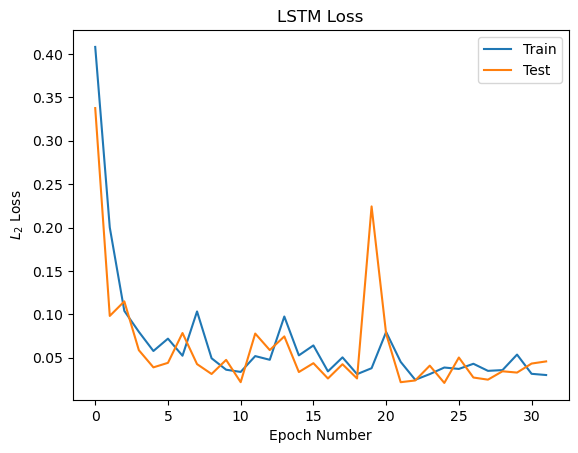

In [20]:

plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.title("LSTM Loss")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig("lstm.eps")

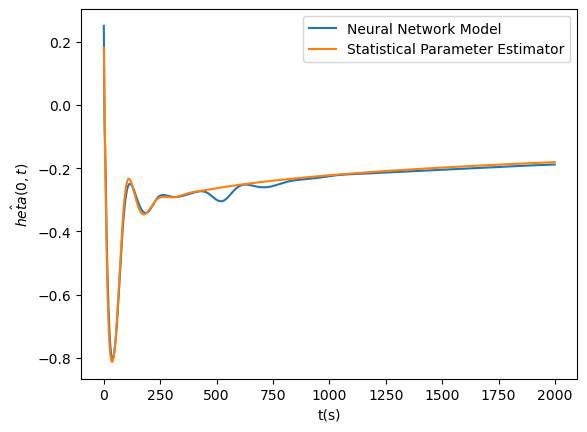

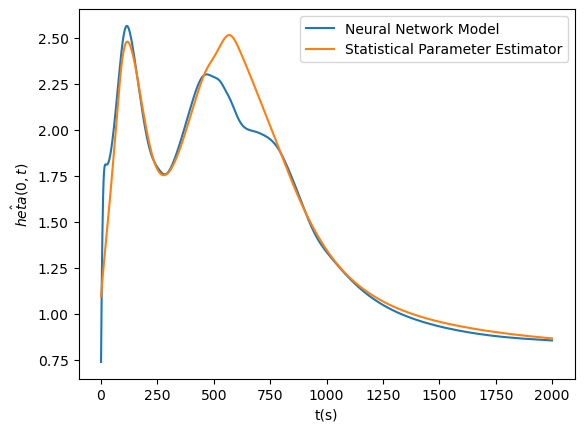

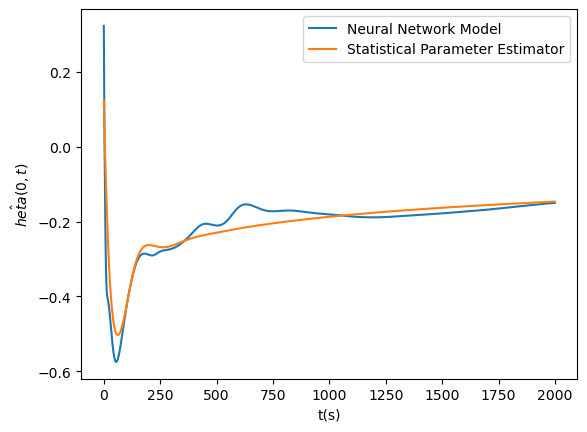

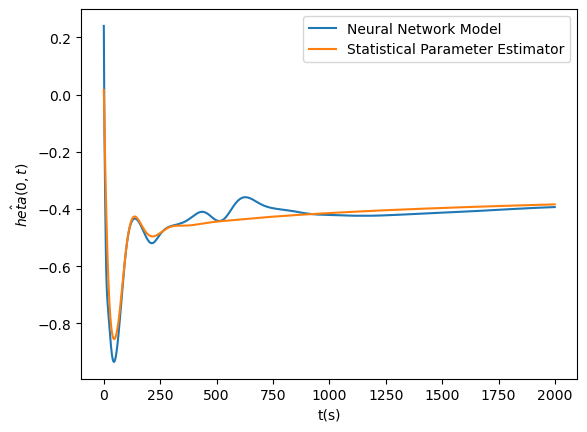

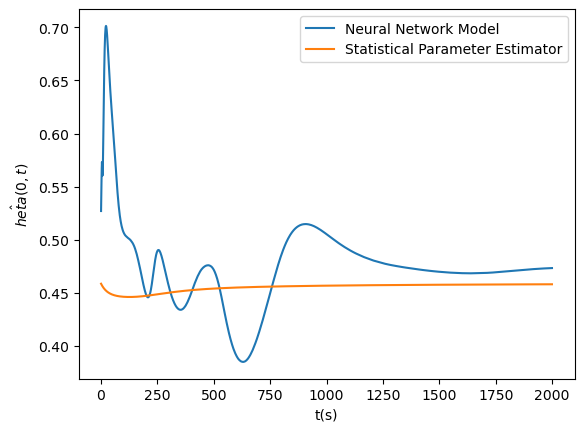

In [10]:
# Show some examples at the boundry
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        out = y_normalizer.decode(out)
        plt.figure()
        plt.plot(out[0,:, 0].detach().cpu(), label="Neural Network Model")
        plt.plot(y[0, :, 0].detach().cpu(), label="Statistical Parameter Estimator")
        plt.legend()
        plt.xlabel("t(s)")
        plt.ylabel("$\hat{\theta}(0, t)$")

In [11]:
with torch.no_grad():
    test_mse = 0
    mse_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        out = model(x)
        out = y_normalizer.decode(out)    

        test_mse += loss(out, y).item()
print("TEST MSE For 20 Instances:", test_mse/len(testData))

TEST MSE For 20 Instances: 0.005876395385712385


In [12]:
torch.save(model.state_dict(), 'lstmModel1')